In [88]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [89]:
series1 = pd.read_csv("mean-monthly-air-temperature-deg.csv")['Deg']

In [90]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [91]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [92]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [93]:
def plot_tema(alpha, beta, gamma, ser=series1, ser_to_plot=series1, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

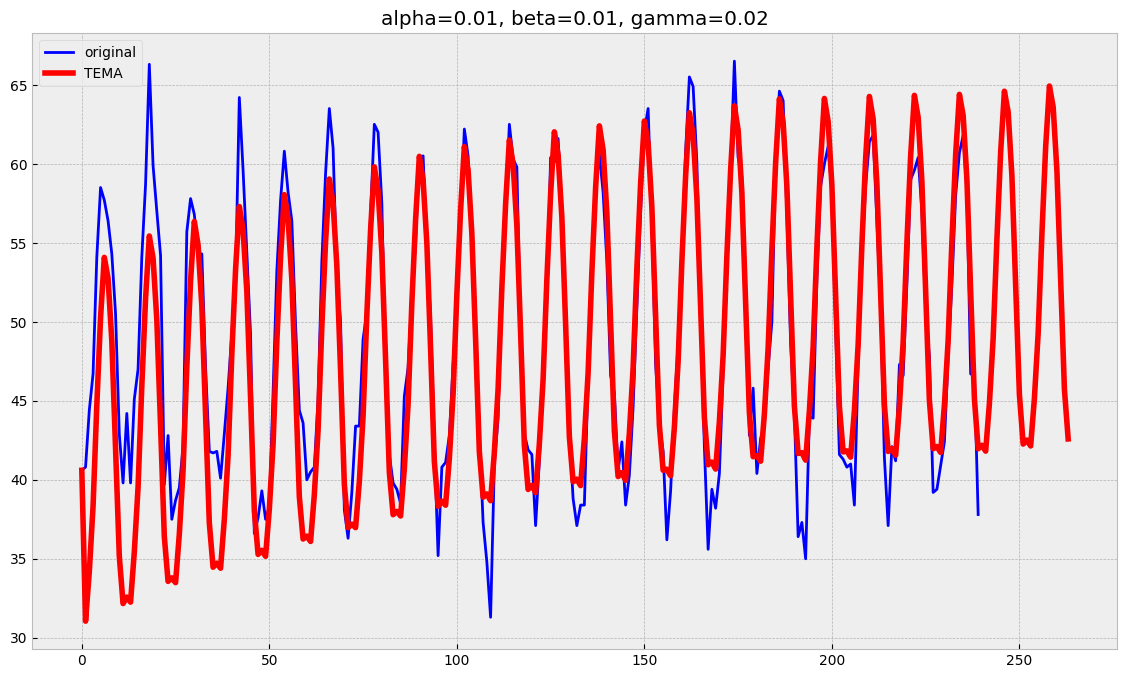

In [94]:
plot_tema(0.01, 0.01, 0.02)

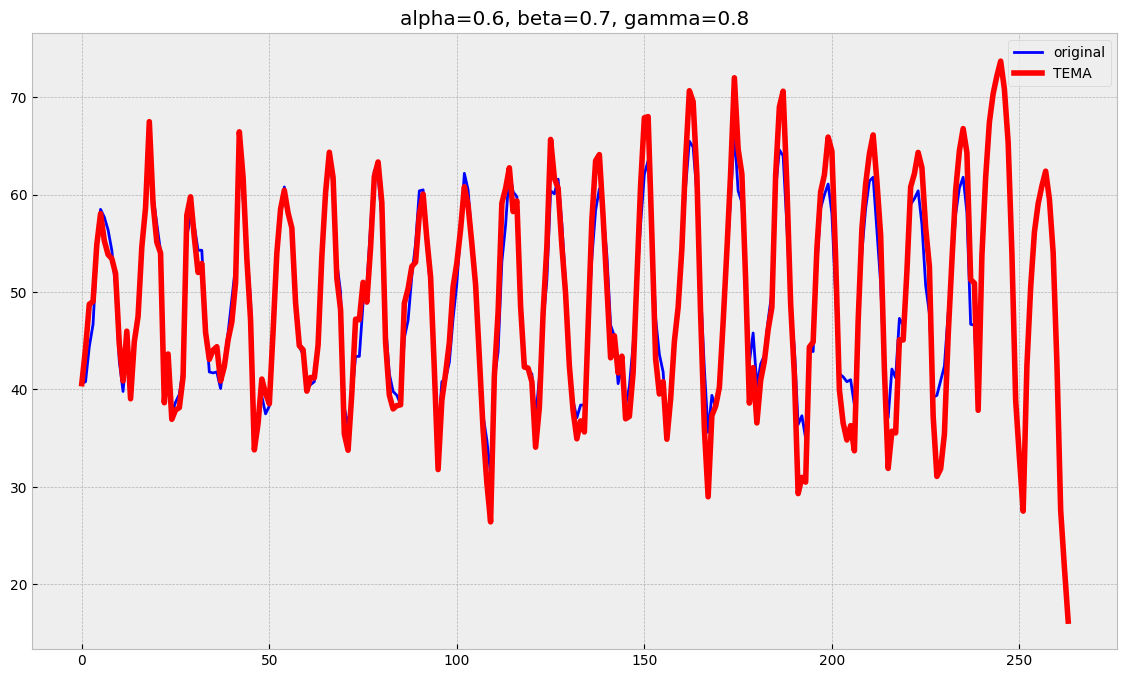

In [95]:
plot_tema(0.6, 0.7, 0.8)

In [96]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [97]:
train, test, val = series1[:60], series1[60:70], series1[70:]

In [98]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [99]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [100]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 6.888572100694451
        x: [ 1.000e+00  0.000e+00  1.000e+00]
      nit: 1
      jac: [-3.862e+00  2.184e+02 -0.000e+00]
     nfev: 8
     njev: 2
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


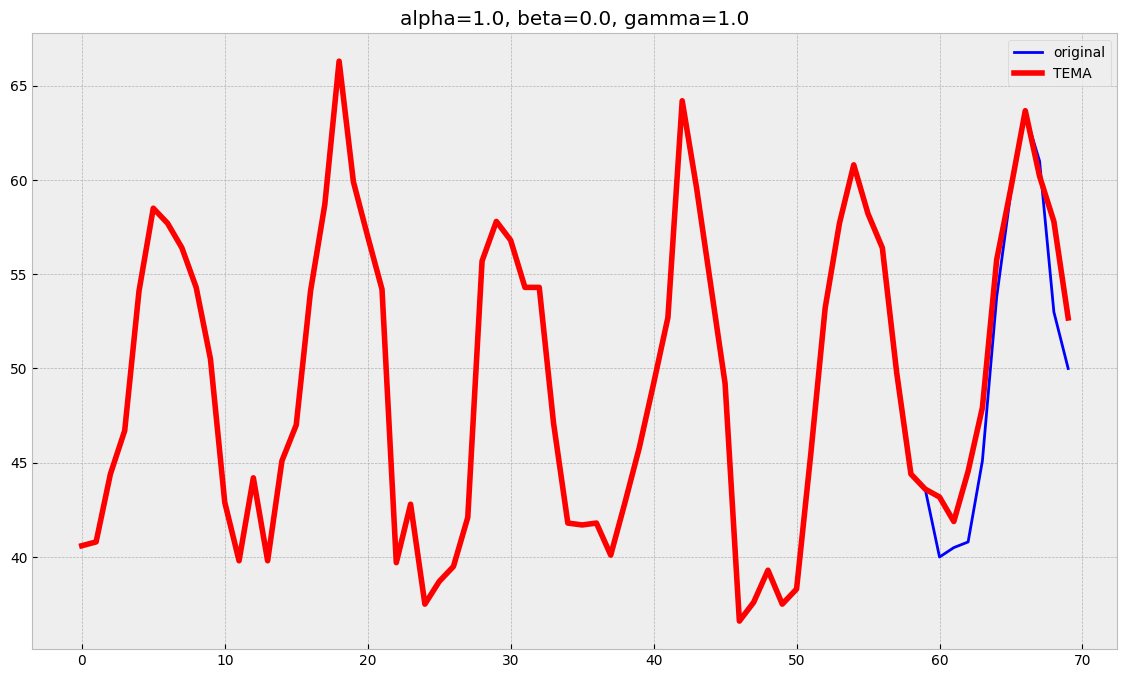

In [101]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series1[:70], n_preds=len(test))

In [153]:
series2 =  pd.read_csv('weekly-closings-of-the-dowjones-.csv')['Close']

In [154]:
train, test, val = series2[:60], series2[60:70], series2[70:]

In [155]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [156]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 52.345967733585496
        x: [ 3.688e-01  1.203e-02  3.862e-01]
      nit: 21
      jac: [ 8.853e-04 -2.346e-03 -8.150e-04]
     nfev: 144
     njev: 36
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


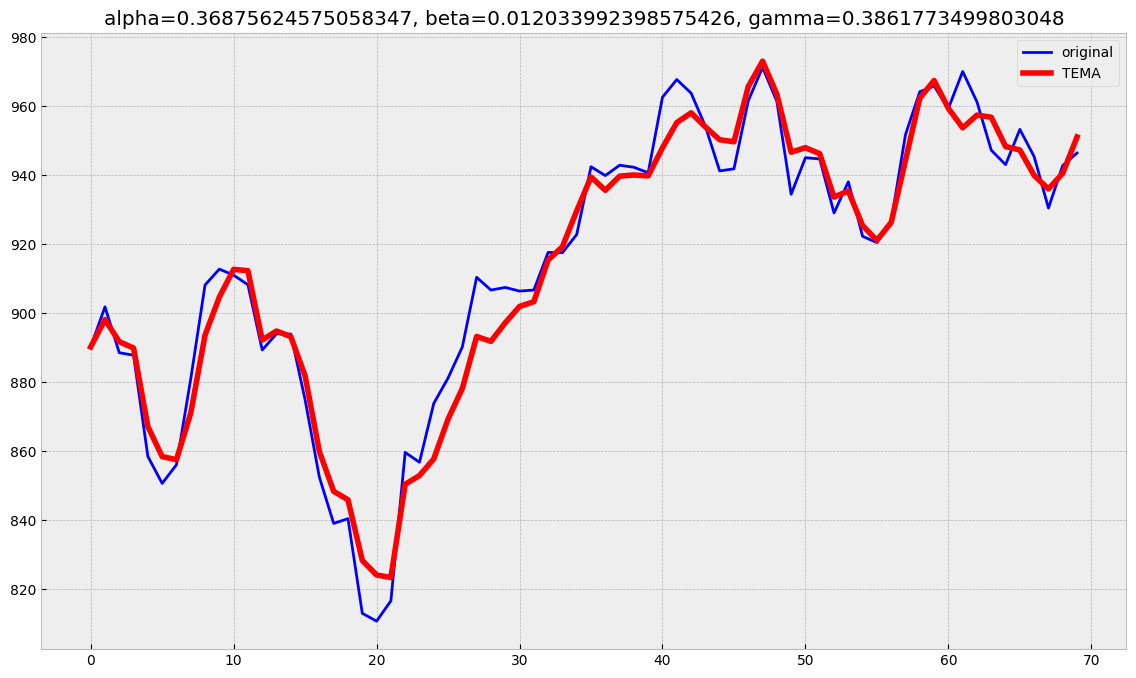

In [158]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series2[:70], n_preds=len(test))

In [159]:
series2 = boxcox(series2, 0)
series2 = np.diff(series2, 1)

In [160]:
train, test, val = series2[:60], series2[60:70], series2[70:]

In [161]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [162]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.00013162995072740565
        x: [ 5.832e-02  0.000e+00  1.917e-02]
      nit: 10
      jac: [-2.776e-06  1.886e-04 -6.709e-06]
     nfev: 52
     njev: 13
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


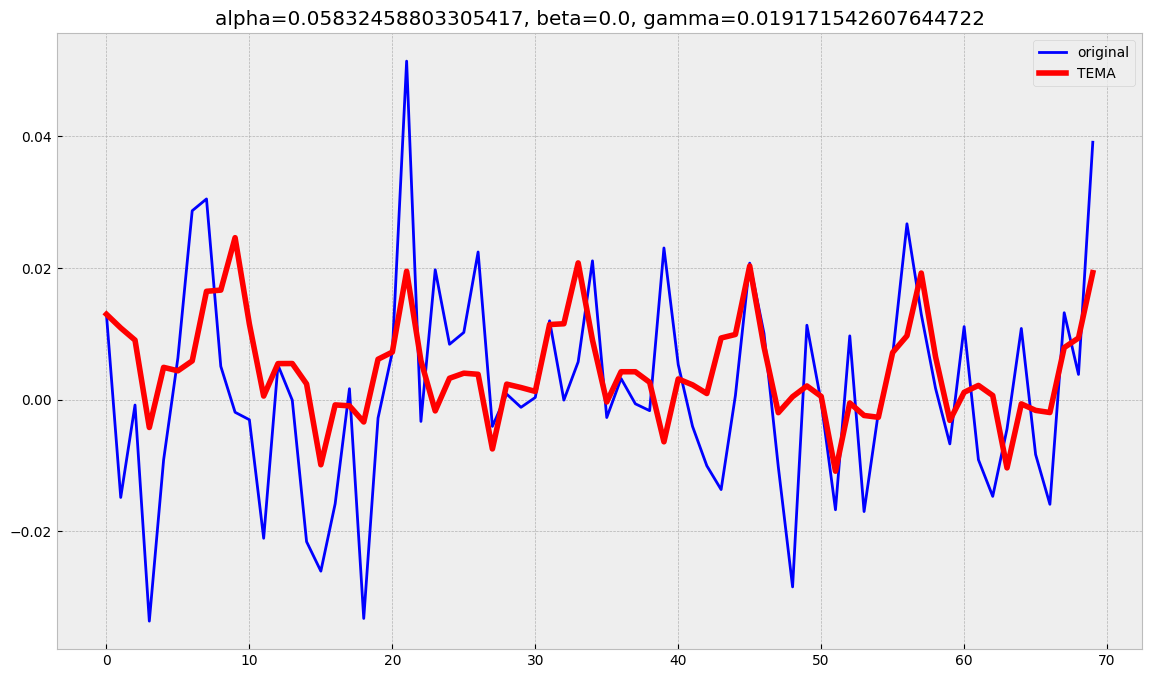

In [163]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series2[:70], n_preds=len(test))

Я решила воспользоваться методом Хольта-Винтерса, чтоб посмотреть как он работает на стационарных, и нестационарных временных рядах. Как видим, со стационарным рядом эта модель работает гораздо лучше, чем с не стацинарным
